### Bulid the Environment

In [1]:
!pip install -q transformers
!pip install -q datasets
!pip install -U albumentations opencv-python
!pip install -q git+https://github.com/huggingface/transformers.git datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


+
### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import json
from torch.utils.data import Dataset, DataLoader
from transformers import Trainer, TrainingArguments, BeitFeatureExtractor, BeitForImageClassification, BeitForSemanticSegmentation, default_data_collator
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from PIL import Image
import torch
import cv2
import random
from sklearn.metrics import f1_score
from huggingface_hub import cached_download, hf_hub_url
import torchvision


In [3]:
RANDOM_SEED = 56
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

###Load Model and Feature Extractor

In [4]:

model_name = "microsoft/beit-base-finetuned-ade-640-640"
feature_extractor = BeitFeatureExtractor(do_resize=True, size=640, do_center_crop=False)
model = BeitForSemanticSegmentation.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.8/dist-packages/transformers/models/beit/feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(


BeitForSemanticSegmentation(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): BeitPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relative_position_bias): BeitRelativePositionBias()
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (in

###Load DataSet

In [5]:
from datasets import load_dataset

# load image + ground truth map
ds = load_dataset("scene_parse_150", split="test")
#ds = load_dataset("hf-internal-testing/fixtures_ade20k", split="test"

In [6]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg



image =[]
segmentation_map =[] = []
#pixel_values = []
#outputs = []
#logits = []
for i in range(4):
  image.append(ds[i]["image"])
  segmentation_map.append(ds[1]["image"])


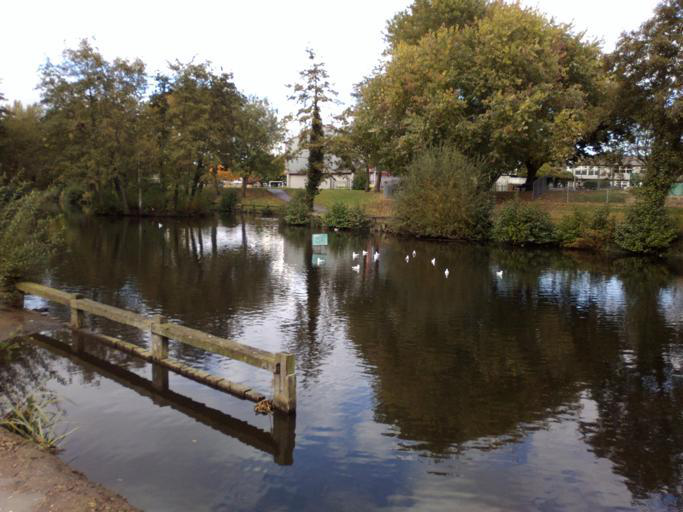

In [7]:
image[0]

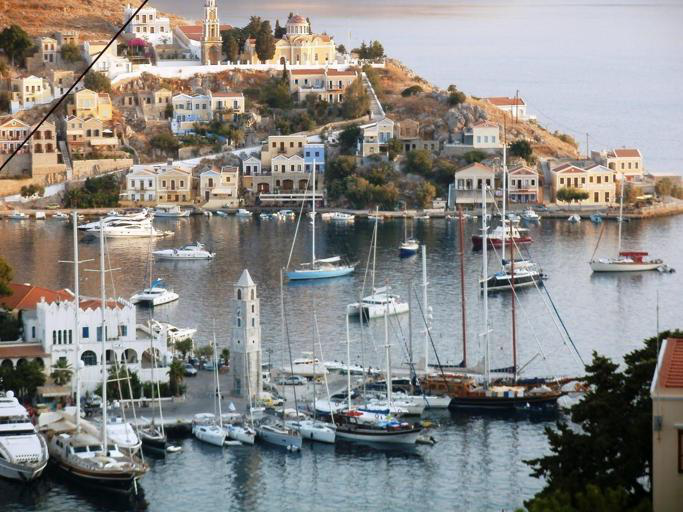

In [8]:
image[1]

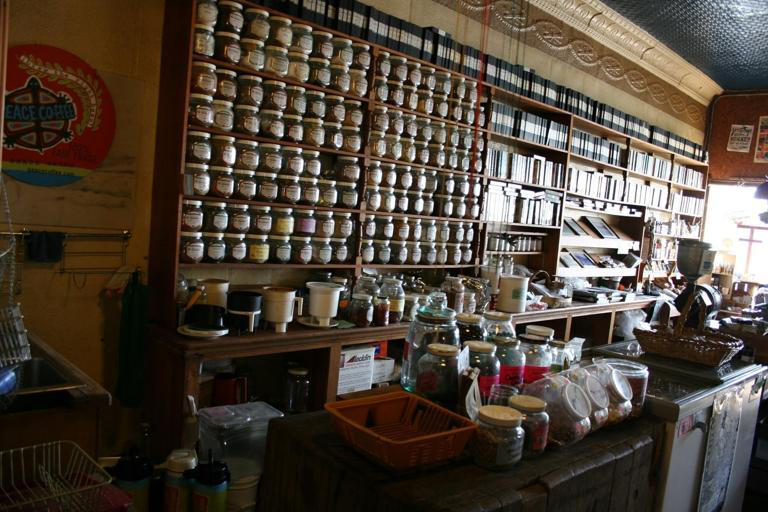

In [9]:
image[2]

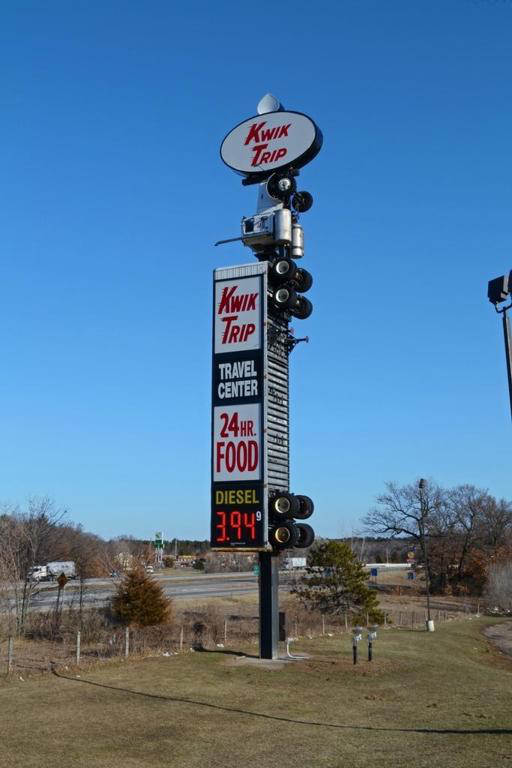

In [10]:
image[3]

In [11]:
!pip show torch

Name: torch
Version: 1.13.0+cu116
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.8/dist-packages
Requires: typing-extensions
Required-by: fastai, torchaudio, torchtext, torchvision


In [12]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

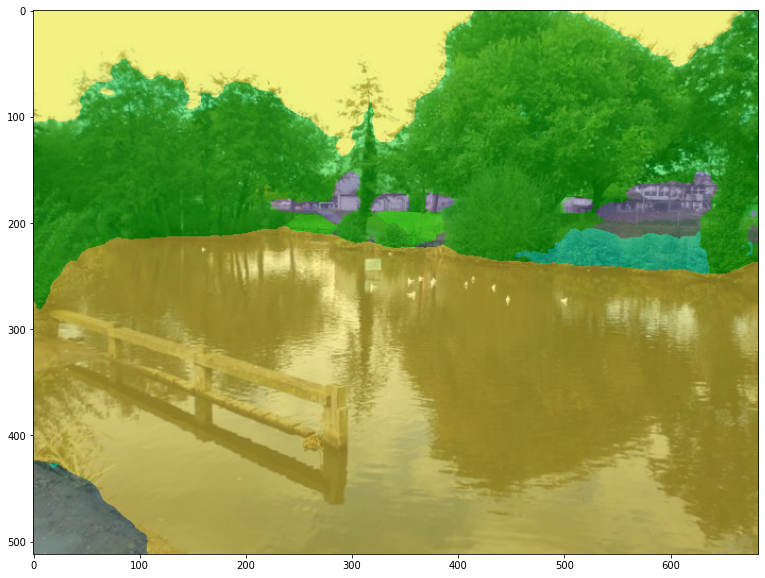

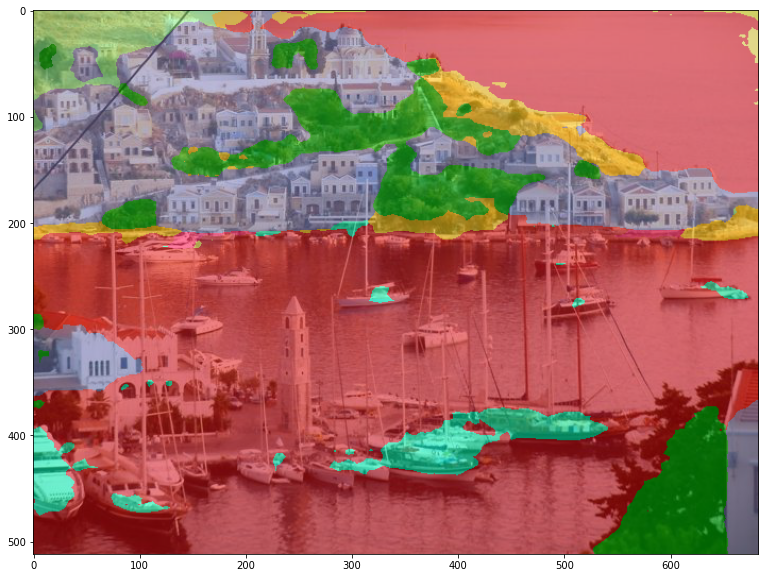

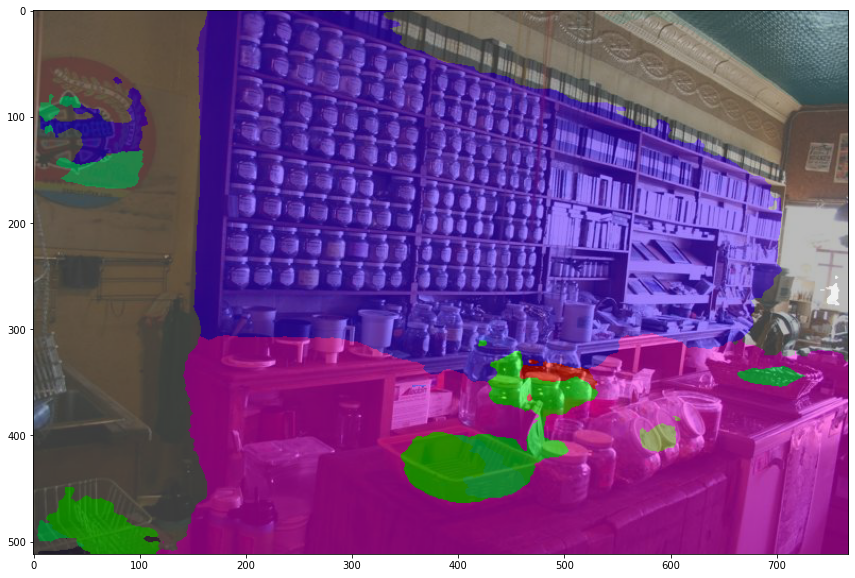

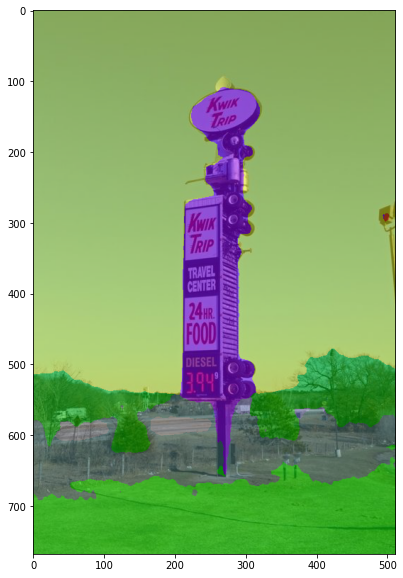

In [13]:
from torch import nn
import matplotlib.pyplot as plt

for i in range(len(image)):
  pixel_values = feature_extractor(image[i], return_tensors="pt").pixel_values.to(device)
  outputs = model(pixel_values)
  logits = outputs.logits
  # First, rescale logits to original image size
  logits = nn.functional.interpolate(outputs.logits,
                  size=image[i].size[::-1], # (height, width)
                  mode='bilinear',
                  align_corners=False)

  # Second, apply argmax on the class dimension
  seg = logits.argmax(dim=1)[0].cpu()
  color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
  palette = np.array(ade_palette())
  for label, color in enumerate(palette):
      color_seg[seg == label, :] = color
  # Convert to BGR
  color_seg = color_seg[..., ::-1]

  # Show image + mask
  img = np.array(image[i]) * 0.5 + color_seg * 0.5
  img = img.astype(np.uint8)

  plt.figure(figsize=(15, 10))
  plt.imshow(img)
  plt.show()

In [14]:
feature_extractor = BeitFeatureExtractor.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')
model_class = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')
for i in range(len(image)):
  inputs = feature_extractor(images= image[i], return_tensors="pt")
  outputs = model_class(**inputs)
  logits = outputs.logits
  predicted_class_idx = logits.argmax(-1).item()
  print("Predicted class:", model_class.config.id2label[predicted_class_idx])

Predicted class: town_hall
Predicted class: harbor, harbour
Predicted class: country_store, general_store, trading_post
Predicted class: motel


In [15]:
from torch import nn
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      BeitForImageClassification.from_pretrained("microsoft/beit-base-patch16-224"),
     # nn.Flatten(),
      nn.Linear(150, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 10)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

In [16]:
#model_name = "microsoft/beit-base-finetuned-ade-640-640"
feature_extractor = BeitFeatureExtractor(do_resize=True, size=32, do_center_crop=False)
#model = BeitForImageClassification.from_pretrained(model_name)
net = MLP()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

MLP(
  (layers): Sequential(
    (0): BeitForImageClassification(
      (beit): BeitModel(
        (embeddings): BeitEmbeddings(
          (patch_embeddings): BeitPatchEmbeddings(
            (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): BeitEncoder(
          (layer): ModuleList(
            (0): BeitLayer(
              (attention): BeitAttention(
                (attention): BeitSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=False)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                  (relative_position_bias): BeitRelativePositionBias()
                )
                (output): BeitSelfOutput(
                  (dense): Linear(in_features=768, out_fe

In [17]:
from torchvision.datasets import CIFAR10
import os
from torchvision import transforms

In [18]:
train_indices = range(0,5)

In [19]:
transform = transforms.Compose([transforms.Resize(size=(224, 224)), transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])
dataset = CIFAR10(os.getcwd(), download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=4,  num_workers=1, sampler=torch.utils.data.sampler.SubsetRandomSampler(train_indices))


Files already downloaded and verified


In [20]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
  
  # Run the training loop
for epoch in range(0, 5): # 5 epochs at maximum
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      
      # Get inputs
      inputs, targets = data
      inputs, targets = inputs.cuda(), targets.cuda()
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = net(inputs)
      
      # Compute loss
      loss = loss_function(outputs, targets)
      
      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
        
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

  # Process is complete.
    print('Training process has finished.')

Starting epoch 1


TypeError: ignored